# Optimización de semáforos para control de tráfico vehicular usando procesos de decisión de markov

Autores: 
- Daniel Alejandro García Hernández
- David Camilo Cortes Salazar

En este notebook se encuentra una implementación de un algoritmo de Q-Learning para un modelo de control de intersección simple para optimización del tráfico vehicular.

Las librerías necesarias para ejecutar el código son:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

---
Inicialmente, declaramos las siguientes variables globales que sirven como parámetros de nuestro modelo:

- max_carros: Representa el máximo de carros que puede haber en cada fila de espera
- lambda_ns: Tasa de llegada para autos en sentido Norte-Sur
- lambda_sn: Tasa de llegada para autos en sentido Sur-Norte
- lambda_eo: Tasa de llegada para autos en sentido Este-Oeste
- lambda_oe: Tasa de llegada para autos en sentido Oeste-Este
- acciones: Representa las acciones que puede tomar el agente. '0' implica que se va a mantener la configuración actual de luces verdes y rojas; '1' implica que se cambiará la configuración, de tal forma que se de luz verde a la via contraria, roja a la actual.

In [55]:
max_carros = 10 # Por cada cola, NO en total
lambda_ns = 0.2  # Tasa de llegada para Norte-Sur
lambda_sn = 0.15  # Tasa de llegada para Norte-Sur
lambda_eo = 0.1  # Tasa de llegada para Este-Oeste
lambda_oe = 0.1  # Tasa de llegada para Este-Oeste
acciones = [0, 1]  # 0: mantener, 1: cambiar

A continuación, generamos el espacio de estados. Esto no supone un problema de almacenamiento de memoria, pues al tener máximo 10 autos por fila se tiene un total de 29282 estados:

In [3]:
# Generamos todos los estados posibles
estados = []
for n in range(max_carros + 1):
    for m in range(max_carros + 1):
        for k in range(max_carros + 1):
            for t in range(max_carros + 1):
                for s in [0, 1]:
                    estados.append((n, m, k, t, s))

Como nuestro espacio de estados es manejable, podemos generar la Q-table de manera estática, y así simplificar el código de la fase de entrenamiento

In [4]:
# Inicializar la tabla Q con ceros
Q_table = {}
for estado in estados:
    Q_table[estado] = np.zeros(len(acciones))

### Algortimo

Para nuestro algoritmo de Q-Learning necesitamos definir los siguientes hiperparámetros de aprendizaje:

- $\alpha$: Tasa de aprendizaje del agente.
- $\gamma$: Tasa de descuento para la recompensa.
- simulaciones: Número de episodios con los que el agente será entrenado.

Además, definiremos unos parámetros para nuestro $\epsilon$ de la siguiente manera:

- $\epsilon _ \text{inicial}$: Es el valor que toma nuestro $\epsilon$ al inicio del entrenamiento.
- $\epsilon _ \text{final}$: Es el valor más pequeño que puede tomar nuestro $\epsilon$ durante el entrenamiento.
- $\epsilon _ \text{decre}$: Define el decrecimiento de nuestro $\epsilon$ con el paso de cada episodio. Se define como:

$$ $\epsilon _ \text{decre}$ = \frac{\epsilon_{final}}{\epsilon_{inicial}}^{\frac{1}{0.8\times E}}$$

Donde $E$ es el número de episodios (en nuestro caso, la variable simulaciones).

Con estas variables definidas podemos usar una estrategia $\epsilon -$greedy en nuestro algoritmo. En esta, en los primeros episodios se prioriza la exploración de nuevos estados, y a medida, que se avance en el tiempo, la prioridad del agente cambia a la explotación de los valores calculados durante la exploración.

In [56]:
alpha = 0.2 # Tasa de aprendizaje (entre 0.1 y 0.5) (valores altos -> rapido e inestable) (valores bajos -> lento y estable)
gamma = 0.95  # Factor de descuento (entre 0.9 y 0.99) (valores altos -> recompensas a futuro) (valores bajos -> recompensas cercanas)
epsilon_inicial = 1.0
epsilon_final = 0.01
simulaciones = 10000

decre_simulacion = int(simulaciones * 0.8) 
epsilon_decre = (epsilon_final / epsilon_inicial) ** (1 / decre_simulacion)

La función de transición de nuestro agente define los pasos en tiempo discreto de nuestro modelo. Aquí, en cada cambio de estado, un auto puede salir de la cola de espera si su semáforo está se encuentra en verde, o cambia a verde en este periodo de tiempo. 

Para esto, se define:

- Una recompensa de $1$ a nuestro agente por cada auto que atraviese la intersección.
- Penalización de $-0.5$ por cada acción de cambio en el valor del semáforo. Esto se hace para evitar una política de cambio constante.
- Penalización de $-0.1$ por cada auto en espera.


In [51]:
def paso_discreto(estado, accion):
    n, m, k, t, s = estado
    recompensa = 0

    # Llegada de nuevos carros bajo Poisson
    nuevos_ns = np.random.poisson(lambda_ns)
    nuevos_eo = np.random.poisson(lambda_eo)
    nuevos_sn = np.random.poisson(lambda_sn)
    nuevos_oe = np.random.poisson(lambda_oe)

    n = min(n + nuevos_ns, max_carros)
    m = min(m + nuevos_eo, max_carros)
    k = min(k + nuevos_sn, max_carros)
    t = min(t + nuevos_oe, max_carros)

    # Si cambia
    if accion == 1:
        s = 1 - s  # Cambiar estado del semáforo
        recompensa -= 0.5  # penalizacion de cambio

    if s == 0: # Si esta en NS o SN
        if n > 0:
            n -= 1 # Pasa un auto
            recompensa += 1
        if k > 0:
            k -= 1 # Pasa un auto
            recompensa += 1
    elif s == 1:# Si esta en EO o OE
        if m > 0:    
            m -= 1 # Pasa un auto
            recompensa += 1
        if t > 0:    
            t -= 1 # Pasa un auto
            recompensa += 1

    # Penalizacion autos en espera
    recompensa -= 0.1 * (n + m + k + t)

    # Estado actualizado
    sig_estado = (n, m, k, t, s)

    return sig_estado, recompensa


Con todo lo anterior, solo queda implementar nuestro algoritmo de entrenamiento. Este sigue los siguientes pasos en cada episodio:

1. Se observa el estado actual.
2. Selección de una acción mediante la estrategia $\epsilon$-greedy: con probabilidad $p= \epsilon$ se elige una acción aleatoria, y con probabilidad $p= 1-\epsilon$ se elige usando la mejor acción de la política actual.
3. Calcula las recompensas obtenidas con la decision tomada.
4. Cambia de estado según la acción elegida
5. Actualiza la Q-table mediante la ecuación:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ R(s_t, a_t) + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right]$$

6. Si aún no termina el episodio actual, vuelve al paso **1.**. En caso contrario, continúa en **7.**

7. Actualiza el $\epsilon$
   
8.  Pasa al siguiente episodio

In [57]:
epsilon = epsilon_inicial

# Analisis de recompensas
recompensas_simulaciones = [] # recompensas por simulacion

# Analisis de convergencia  
valores_delta_q = []
Q_table_anterior = None

# Analisis de politica
cambios_politica = []
politica_anterior = None

# Análisis de carros en cola
carros_cola = []

for simulacion in range(simulaciones):
    
    # Estado inicial aleatorio
    estado = (np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.choice([0, 1]))

    terminar = False
    recompensa_total = 0
    pasos = 0
    carros_esperando = 0

    while not terminar:
    
        if np.random.rand() < epsilon:
            accion = np.random.choice(acciones)
        else:
            accion = np.argmax(Q_table[estado]) 

        sig_estado, recompensa = paso_discreto(estado, accion)

        # Actualización de Q-learning
        sig_mejor_accion = np.argmax(Q_table[sig_estado])

        td_objetivo = recompensa + gamma * Q_table[sig_estado][sig_mejor_accion] # R + gamma * Q(St+1, a)
        td_error = td_objetivo - Q_table[estado][accion] # td_target - Q(S, A)

        Q_table[estado][accion] += alpha * td_error # Q(S, A) + alpha *  -> Actualiza probabilidad

        # Actualizar el estado
        estado = sig_estado
        pasos += 1
        
        ## Calcular número promedio de carros que esperan
        carros_esperando += sum(estado[0:4])

        # Condición para terminar el episodio
        if pasos >= 100:
            recompensa_total += recompensa
            terminar = True

    # Decaimiento de epsilon
    if epsilon > epsilon_final:
        epsilon *= epsilon_decre
    else:
        epsilon = epsilon_final

    # Analisis de Recompensas
    recompensas_simulaciones.append(recompensa_total)

    # Analsiis de Convergencia
    if Q_table_anterior is not None:
        delta_Q = 0
        for estado in Q_table:
            delta_Q += np.sum(np.abs(Q_table[estado] - Q_table_anterior[estado]))
        valores_delta_q.append(delta_Q / len(acciones)*len(estados))

        # Analisis de Politica
        cambios = sum(np.argmax(Q_table[estado]) != np.argmax(Q_table_anterior[estado]) for estado in Q_table)
        cambios_politica.append(cambios / len(estados))

    
        ## Análisis de carros en cola
        carros_cola.append(carros_esperando/100)



    Q_table_anterior = deepcopy(Q_table)

    # Mostrar progreso cada 100 simulaciones
    if (simulacion + 1) % (simulaciones // 100) == 0:
        print(f'Episodio {simulacion + 1}/{simulaciones}, epsilon: {epsilon:.4f}')


Episodio 100/10000, epsilon: 0.9441
Episodio 200/10000, epsilon: 0.8913
Episodio 300/10000, epsilon: 0.8414
Episodio 400/10000, epsilon: 0.7943
Episodio 500/10000, epsilon: 0.7499
Episodio 600/10000, epsilon: 0.7079
Episodio 700/10000, epsilon: 0.6683
Episodio 800/10000, epsilon: 0.6310
Episodio 900/10000, epsilon: 0.5957
Episodio 1000/10000, epsilon: 0.5623
Episodio 1100/10000, epsilon: 0.5309
Episodio 1200/10000, epsilon: 0.5012
Episodio 1300/10000, epsilon: 0.4732
Episodio 1400/10000, epsilon: 0.4467
Episodio 1500/10000, epsilon: 0.4217
Episodio 1600/10000, epsilon: 0.3981
Episodio 1700/10000, epsilon: 0.3758
Episodio 1800/10000, epsilon: 0.3548
Episodio 1900/10000, epsilon: 0.3350
Episodio 2000/10000, epsilon: 0.3162
Episodio 2100/10000, epsilon: 0.2985
Episodio 2200/10000, epsilon: 0.2818
Episodio 2300/10000, epsilon: 0.2661
Episodio 2400/10000, epsilon: 0.2512
Episodio 2500/10000, epsilon: 0.2371
Episodio 2600/10000, epsilon: 0.2239
Episodio 2700/10000, epsilon: 0.2113
Episodio 2

Exportamos la política a un archivo


In [13]:
import json

archivo = "q_table.json"

Q_table_keys = {str(key): value.tolist() for key, value in Q_table.items()}
with open(archivo, 'w') as f:
    json.dump(Q_table_keys, f)


### Evaluar rendimiento

En este punto tenemos una Q-table ya entrenada y lista para usarse en diferentes evaluaciones. Veamos las recompensas obtenidas por el agente en algunas de ellas para distintos pasos de entrenamiento:

In [18]:
for i in range(10):
    estado = (np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.choice([0, 1]))
    recompensa_total = 0
    pasos = 0
    max_pasos = 10**((i%3)+1)

    while pasos < max_pasos:
        accion = np.argmax(Q_table[estado])  # Seleccionar la mejor acción
        sig_estado, recompensa = paso_discreto(estado, accion)
        recompensa_total += recompensa
        estado = sig_estado
        pasos += 1

    print(f'Evaluacion: {i}\t Pasos: {max_pasos}:\t Recompensa total: {recompensa_total}')


Evaluacion: 0	 Pasos: 10:	 Recompensa total: 6.599999999999999
Evaluacion: 1	 Pasos: 100:	 Recompensa total: 28.599999999999984
Evaluacion: 2	 Pasos: 1000:	 Recompensa total: 374.99999999999943
Evaluacion: 3	 Pasos: 10:	 Recompensa total: 7.999999999999999
Evaluacion: 4	 Pasos: 100:	 Recompensa total: 51.699999999999974
Evaluacion: 5	 Pasos: 1000:	 Recompensa total: 368.1999999999992
Evaluacion: 6	 Pasos: 10:	 Recompensa total: 0.7999999999999989
Evaluacion: 7	 Pasos: 100:	 Recompensa total: 40.199999999999974
Evaluacion: 8	 Pasos: 1000:	 Recompensa total: 342.2999999999996
Evaluacion: 9	 Pasos: 10:	 Recompensa total: 4.999999999999998


Note que tomamos $\alpha = 0.2$, un valor pequeño. Esto genera que nuestro agente priorice la obtención de recompensas a largo plazo. Por esto, en las evaluaciones donde solo ocurrieron 10 pasos la recompensa fue cercana a 0. La política que el agente conoce está pensada a dar mejores resultados a futuro, por lo que en evaluaciones con mayor número de pasos se puede ver como la recompensa aumenta enormemente.

### Cambio en Recompensas:

Veamos como evoluciono el cálculo de recompensas durante la ejecución del algoritmo:

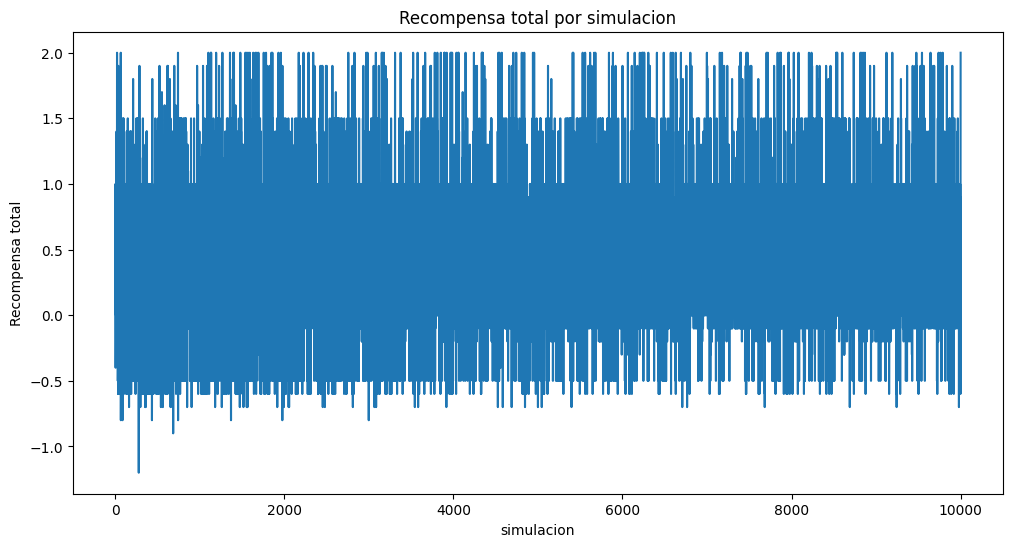

In [12]:

plt.figure(figsize=(12, 6))
plt.plot(recompensas_simulaciones)
plt.xlabel('simulacion')
plt.ylabel('Recompensa total')
plt.title('Recompensa total por simulacion')


#valor_minimo = np.percentile(recompensas_simulaciones, 5)
# = np.percentile(recompensas_simulaciones, 95)


plt.show()

Debido a la naturaleza aleatoria de cada simulación, esta gráfica tiene mucho ruido aleatorio. Por lo tanto, estudiemos los resultados bajo la lupa de una media móvil

### Recompensa promedio:

Veamos como evoluciona la recompensa promedio móvil. Para esto, definimos la media móvil como:

$$ PM_{t} = \frac{1}{k} \sum_{i=t-k+1} x_{i}$$

Donde:

- $x_{i}$ es el valor de la recompensa en la simulación $i$
- $t$ es la época de simulación actual
- $k$ es el numero de datos a promediar, donde $k \geq t$

Este $k$ se conoce como tamaño de la ventana del promedio móvil, y en nuestro caso lo tomamos como valores entre 5% y 10% de las simulaciones, para tener un buen suavizado en los datos sin perder valores importantes

Ahora veamos como se ve este promedio para cada simulación:

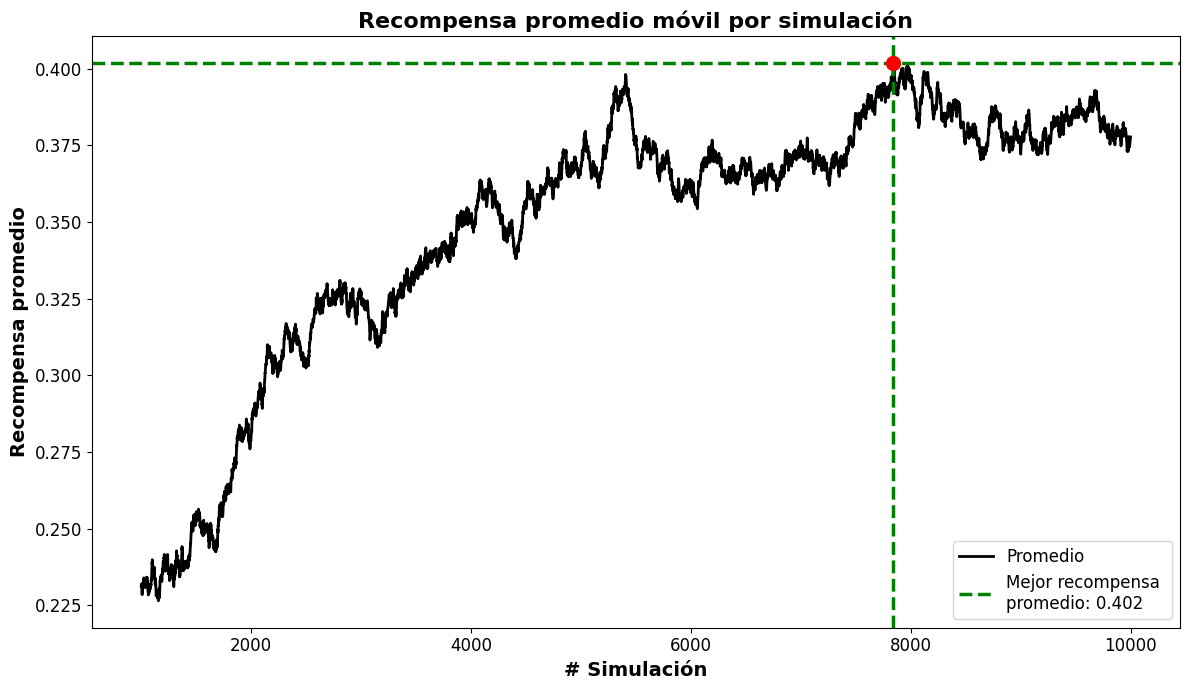

In [58]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'Recompensa_movil'
y_values = recompensas_simulaciones

size = int(simulaciones*0.10)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg, color='k', linewidth=2, label='Promedio')

plt.scatter(max_index + size, max_value, color='red', marker='o', s=100, zorder=10)
plt.axvline(max_index + size, color='g', linestyle='--', linewidth=2.5)
plt.axhline(max_value, color='g', linestyle='--', label=f'Mejor recompensa \npromedio: {max_value:.3f}', linewidth=2.5)



#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title('Recompensa promedio móvil por simulación', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel('Recompensa promedio', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True) 
plt.tight_layout()
plt.legend(fontsize=12, loc='best')
#plt.savefig(f'Imagenes/{filename}.svg')
#plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

En general hay una tendencia creciente en la recompensa promedio que recibe el agente, indicando que se entrenó adecuadamente.

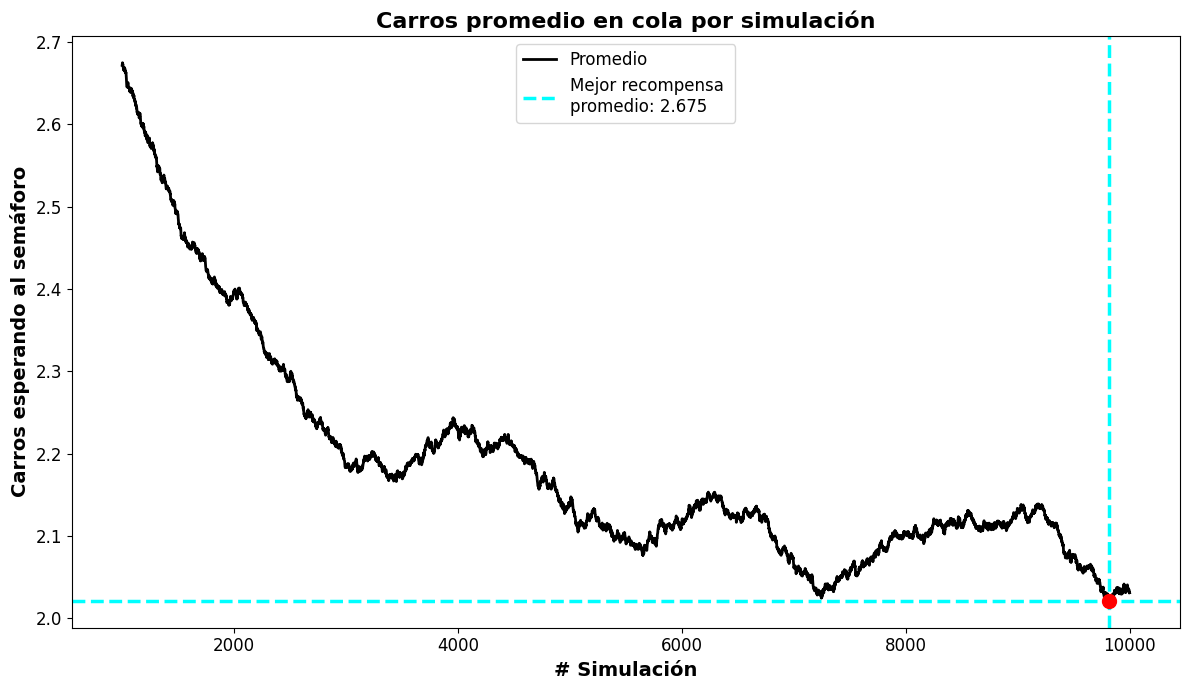

In [59]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'carros_cola'
y_values = carros_cola

size = int(simulaciones*0.10)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

min_index = np.argmin(moving_avg)
min_value = moving_avg[min_index]


plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg, color='k', linewidth=2, label='Promedio')

plt.scatter(min_index + size, min_value, color='red', marker='o', s=100, zorder=10)
plt.axvline(min_index + size, color='cyan', linestyle='--', linewidth=2.5)
plt.axhline(min_value, color='cyan', linestyle='--', label=f'Mejor recompensa \npromedio: {max_value:.3f}', linewidth=2.5)



#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title('Carros promedio en cola por simulación', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel('Carros esperando al semáforo', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=12, loc='best')
#plt.savefig(f'Imagenes/{filename}.svg')
#plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

### Cambio en valores de Q:

Veamos ahora la convergencia del algoritmo. Para esto, definimos el cambio en los valores de Q como:

$$ \Delta Q = \frac{1}{|S| \times |A|} \sum_{s\in S} \sum_{a\in A} |Q_{t+1}(s,a) - Q_{t}(s,a)|

Donde:

- $|S|$ es el espacio de estados
- $|A|$ es el espacio de acciones
- $Q_{t}(s,a)$ es el valor de $Q$ dados $s$ y $a$ en la simulación $t$

Ahora veamos como evolucionó esta cantidad:

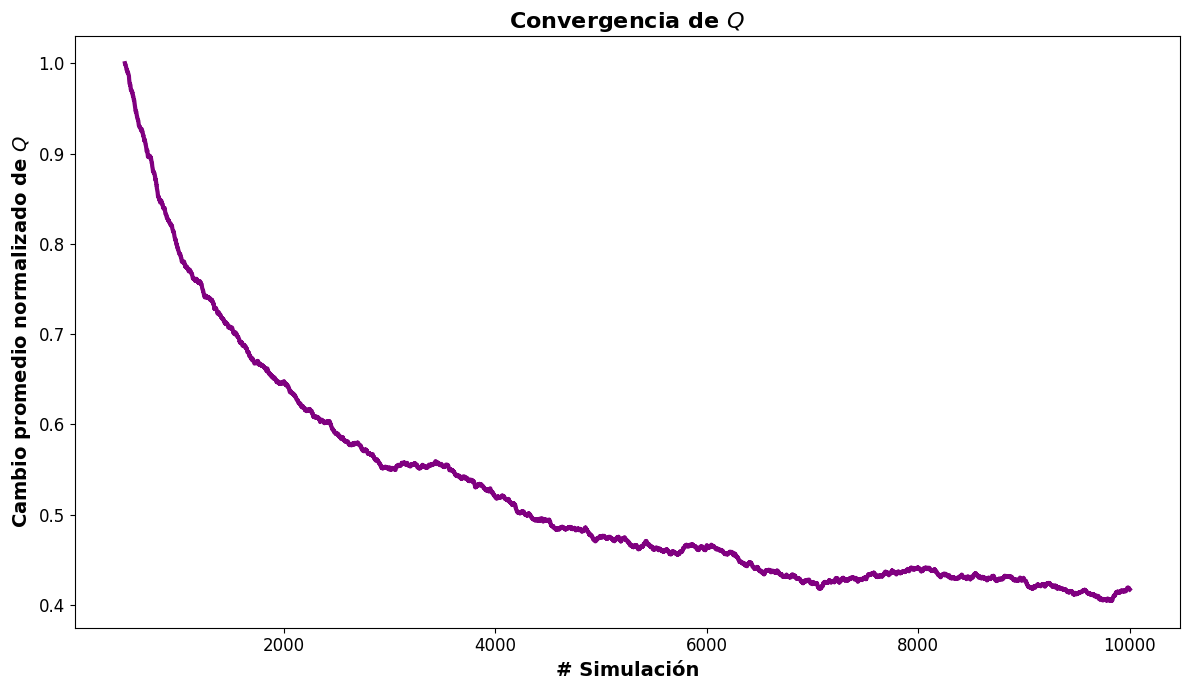

In [60]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'valores_delta_q'
y_values = valores_delta_q

size = int(simulaciones*0.05)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg/max_value, color='purple', linewidth=3, label='Promedio')


#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title(r'Convergencia de $Q$', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel(r'Cambio promedio normalizado de $Q$', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True)
plt.tight_layout()
#plt.legend(fontsize=12, loc='best')

#plt.savefig(f'Imagenes/{filename}.svg')
#plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

Vemos como la diferencia entre valores de $Q$ decrece con el paso de las simulaciones, esto quiere decir que converge a una política óptima mediante el ajuste de valores en cada simulación.

### Cambios en politica:

Finalmente, veamos como cambia la política del agente. Para esto, definimos el cambio en la política como:

$$ \Delta \delta = \sum_{s \in S} \frac{\delta (a_{t}(s), a_{t-1}(s))}{|S|} $$

Donde:

- $|S|$ es el espacio de estados
- $a_{t}(s)$ es la acción óptima a tomar en el estado $s$ en la simulación $t$
- $\delta(x_{1}, x_{2})$ es una función que vale 1 si la acción óptima en el estado $s$ ha cambiado entre la simulación $t$ y $t-1$, y 0 en otro caso.

Veamos la evolución de esta cantidad a lo largo de las simulaciones:

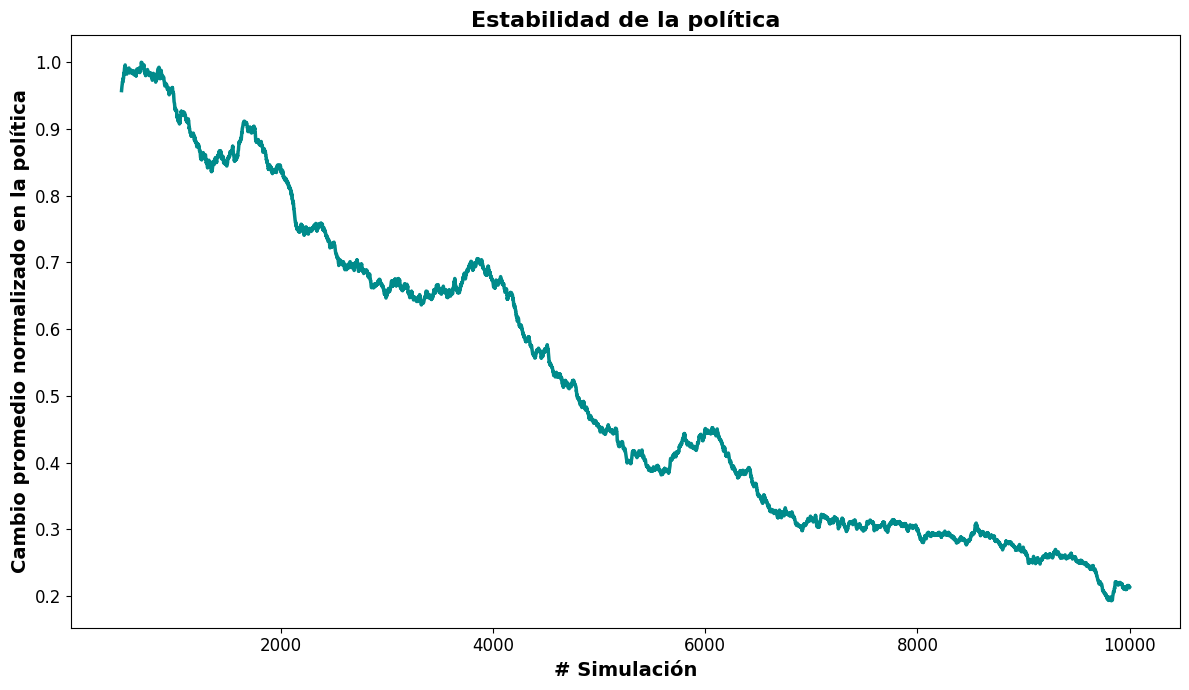

In [61]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'cambios_politica'
y_values = cambios_politica

size = int(simulaciones*0.05)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg/max_value, color='darkcyan', linewidth=2.5, label='Promedio')


#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title(r'Estabilidad de la política', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel(r'Cambio promedio normalizado en la política', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True)
plt.tight_layout()
#plt.legend(fontsize=12, loc='best')

#plt.savefig(f'Imagenes/{filename}.svg')
#plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

Esta gráfica nos da a entender que los cambios en la política tienden a estabilizarse y ser cada vez más pequeños a medida que avanza el algoritmo. Esto es especialmente interesante, pues indica que el agente está encontrando una política que minimiza el tiempo de espera de los autos.